### experiment protocol
#### run:
     source protocol.md
     
#### problem definition
In computer vision, error behavior can have significant effects on decision making. For instance, the wrong estimation of distance can cause a car to stop or in the worst case not stop in the event of an obstacle. Furthermore, false positives can cause failure in control and navigation algorithms that rely on a particular distribution. In our case, we proposed a method for bounding the error in a way that will reduce the overall error and avoid momentary large errors in position estimation.   

#### importance of reaserch
The method presented here although it does not garenteee high accurate result but instead it bounds the error which make it more applicable to serves as input to subsiquent control and navigation, like PID controler and Kalman filter respectively.

#### related work
There is an on going research on the topic of visual inertial odometry. The use of inertial measurement together with vision information implemented in the Rovio project. In their project, they used a dedicated hardware which created synced stereo camera with inertial sensor measurements. In our configuration, we intend to demonstrate significant results with low-cost unsynchronized hardware. 

https://github.com/ethz-asl/rovio

#### testcase description
1. start at a starting height where to potential features are visible
2. extract features
3. climb to a relative position
4. run findEssentialMat to get relative position without scale
5. run recoverPose based on the essential mat to extract rotation vector and translation
6. clean untracked features
7. update translation to the correct scale based on the high difference from stage 3
8. run triangulatePoints based on the two camera positions (stage 1 & 3)
9. move camera at rectangular trajectory looking downwards facing the features
10. run solvePnP to get camera position and orientation

#### type of solvePnP tested
1. solvePnP used in opencv
2. modified solvePnP based on least_square from scipy using the bounded trf method. representing the rotation with axis angle representation
3. modified solvePnP based on least_square from scipy using the bounded trf method. representing the rotation with Euler angles representation

#### methods
###### software 
We developed a software tailored to this specefic problem

##### simulation
Points selected on a grid and created synthetic camera by projecting the points to the camera position. The noise was added to the simulation process after the triangulation. This was done to create a meeningful error in terms of accepted accuracy in triangulation along the Z axis (the height of the camera).
The error adding in this stage represents the problematic behavior of computer vision applications. In a discrete point in time, a wrong estimation can occur which will have long terms effects.

##### RealWorld
###### Haedware
- Sony eye cam II
- sensor gy86 todo: .. information about the sensor .. 

- optitrack system for ground truth information
Since we used a small camera with limited markers mounted on it (4 markers), we were able to extract only 3d position and not 3d orientation. Also in the experiment itself, the camera was held by hand which also made the 3d orientation difficult to obtain due to the blocking of the view from the cameras to the markers.

###### Software
We have developed software in python to evaluate camera position based on the magnetometer readings and the accelerometer readings. We used the simple TRIAD method to obtain the orientation based on the two vectors: the magnetic field vector and the gravitational field vector. We validated this method by calculating the angle between those two vectors over time which should be close to constant. This is a straightforward and fast way to obtain orientation and worked well in a controlled environment and was accurate enough for bounding the least squares algorithm. For obtaining orientation in the general case higher accuracy methods such as ASGD and AHRS should be used.

The computation of the rotation matrix was as folow .... todo


and the relative rotation .... todo



https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19960035751.pdf
http://journals.sagepub.com/doi/full/10.5772/61313

validiation:
todo: show angle between vector graphs


##### todo:
talk about: 
- the distance to ground importance.
- base line increesing after movment and retriangulation (improvment).

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pickle
import numpy as np 
import utils


/home/cosc/student/oga13/learn/localization_tests/transformations.py:1911: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


In [2]:
def read_experiment_file(fname):
    ret=[]
    with open(fname,'rb') as fd:
        try:
            while 1:
                ret.append(pickle.load(fd))
        except EOFError:
            pass
    return ret

def plot_camdiff_pos(ax1,ax2,ex_data,ex_type='sim'):
    extract = lambda x: [(d[1][0],*d[1][2]) for d in ex_data if d[0]==x]
    cam_xyz=np.array(extract('camera'))
    if ex_type=='sim':
        cam_gt_xyz=np.array(extract('camera_gt'))
    elif ex_type=='liveopti':
        cam_gt_xyz= np.array([(d[1][0],*d[1][1].position) for d in ex_data if d[0]=='odata'])
        cam_gt_xyz = cam_gt_xyz[:,[0,3,1,2]]
        cam_gt_xyz[:,2]=-cam_gt_xyz[:,2]

    ax1.plot(cam_xyz[:,0]-cam_xyz[0,0],cam_xyz[:,1],'r')
    ax1.plot(cam_xyz[:,0]-cam_xyz[0,0],cam_xyz[:,2],'g')
    ax1.plot(cam_xyz[:,0]-cam_xyz[0,0],cam_xyz[:,3],'b')
    ax1.plot(cam_gt_xyz[:,0]-cam_xyz[0,0],cam_gt_xyz[:,1],'r',alpha=0.5)
    ax1.plot(cam_gt_xyz[:,0]-cam_xyz[0,0],cam_gt_xyz[:,2],'g',alpha=0.5)
    ax1.plot(cam_gt_xyz[:,0]-cam_xyz[0,0],cam_gt_xyz[:,3],'b',alpha=0.5)
    ax2.plot(cam_xyz[:,1],cam_xyz[:,2],'r')
    ax2.plot(cam_gt_xyz[:,1],cam_gt_xyz[:,2],'m')

def plot_experiment(data_file ,ex_type='sim'):
    data=read_experiment_file(data_file)
    ax1=plt.subplot(1,2,1)
    ax1.set_title(data_file)
    ax2=plt.subplot(1,2,2)
    plot_camdiff_pos(ax1,ax2,data,ex_type)
    ax2.axis('equal')

def plot_experiments(data_file1, data_file2 ,ex_type='sim'):
    data=read_experiment_file(data_file1)
    ax1=plt.subplot(2,2,1)
    ax2=plt.subplot(2,2,2)
    ax1.set_title(data_file1)
    plot_camdiff_pos(ax1,ax2,data,ex_type)
    ax2.axis('equal')
    data=read_experiment_file(data_file2)
    ax1=plt.subplot(2,2,3)
    ax1.set_title(data_file2)
    ax2=plt.subplot(2,2,4)
    plot_camdiff_pos(ax1,ax2,data,ex_type)
    ax2.axis('equal')

def read_3dpoints(fname):
    with open(fname,'rb') as fd:
        try:
            while 1:
                ret=pickle.load(fd)
                if ret[0]=='pts3d':
                    return ret[1][1]
        except EOFError:
            pass
    return None
    
def plot_3dpoints(fname,ax1,ax2,color='b'):
    pts=read_3dpoints(fname)
    ax1.set_title('2d plot of the triangulated 3d points')
    ax1.plot(pts[:,0],pts[:,1],'+'+color)
    ax2.set_title('hist of z axis')
    ax2.hist(pts[:,2],bins=20,range=(-.2,.2),alpha=0.5,color=color)

    
def plot_euler_angles(fname,ax):
    data=read_experiment_file(fname)
    R_camera_gt_ttags=np.array([d[1][0] for d in data if d[0]=='camera_gt'])   
    R_camera_gt=[d[1][1] for d in data if d[0]=='camera_gt']
    R_camera_ttags=np.array([d[1][0] for d in data if d[0]=='camera'])
    
    R_camera_ttags = R_camera_ttags - R_camera_gt_ttags[0]
    R_camera_gt_ttags = R_camera_gt_ttags -R_camera_gt_ttags[0]
    
    R_camera=[d[1][1] for d in data if d[0]=='camera']    
    E_camera_gt=np.array([utils.rotationMatrixToEulerAngles(R)*180.0/np.pi for R in R_camera_gt])
    E_camera=np.array([utils.rotationMatrixToEulerAngles(R)*180.0/np.pi for R in R_camera])
    ax.plot(R_camera_ttags,E_camera[:,0],'r')
    ax.plot(R_camera_ttags,E_camera[:,1],'g')
    ax.plot(R_camera_ttags,E_camera[:,2],'b')
    ax.plot(R_camera_gt_ttags,E_camera_gt[:,0],'r',alpha=0.5)
    ax.plot(R_camera_gt_ttags,E_camera_gt[:,1],'g',alpha=0.5)
    ax.plot(R_camera_gt_ttags,E_camera_gt[:,2],'b',alpha=0.5)


<IPython.core.display.Javascript object>


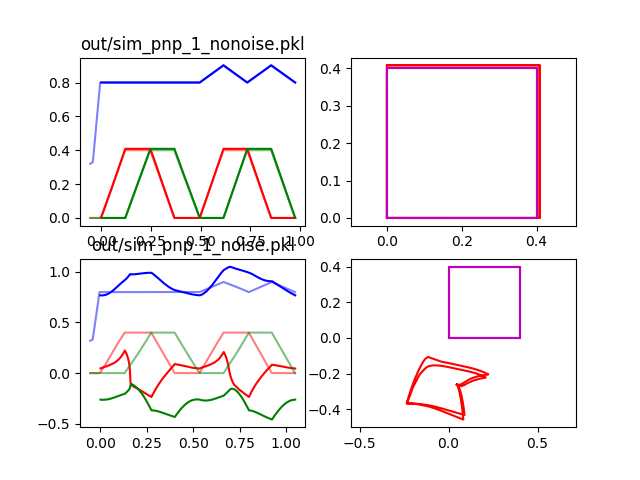

<IPython.core.display.Javascript object>


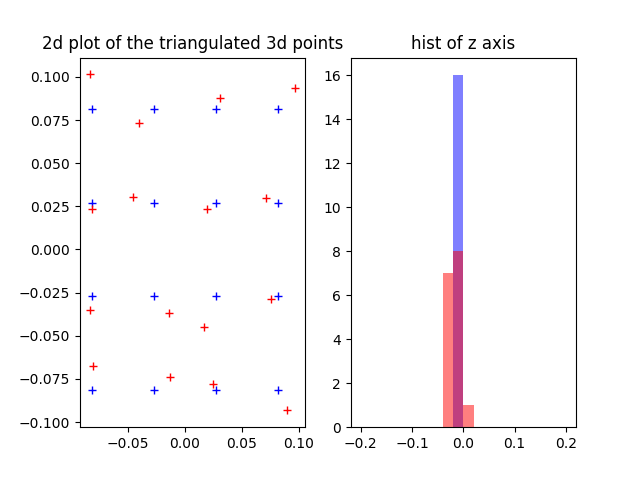

In [3]:
plt.figure()
plot_experiments('out/sim_pnp_1_nonoise.pkl','out/sim_pnp_1_noise.pkl')
plt.figure()
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)
plot_3dpoints('out/sim_pnp_1_nonoise.pkl',ax1,ax2,'b')
plot_3dpoints('out/sim_pnp_1_noise.pkl',ax1,ax2,'r')


<IPython.core.display.Javascript object>


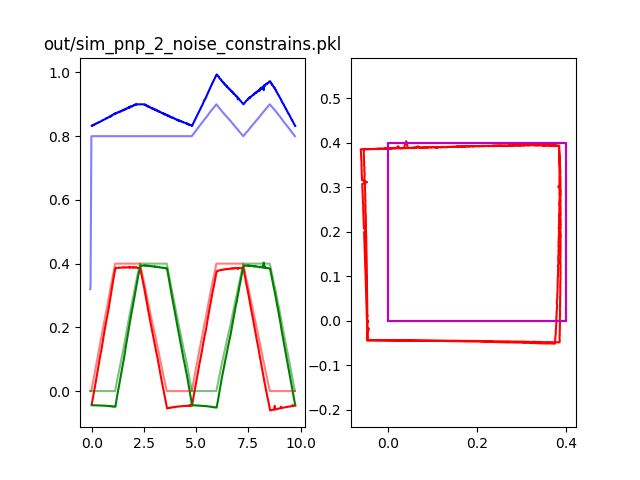

In [4]:
plt.figure()
plot_experiment('out/sim_pnp_2_noise_constrains.pkl')


<IPython.core.display.Javascript object>


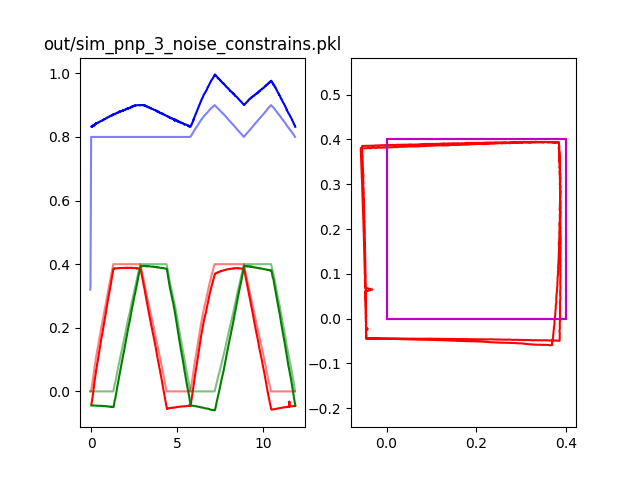

In [5]:
plt.figure()
plot_experiment('out/sim_pnp_3_noise_constrains.pkl')


<IPython.core.display.Javascript object>


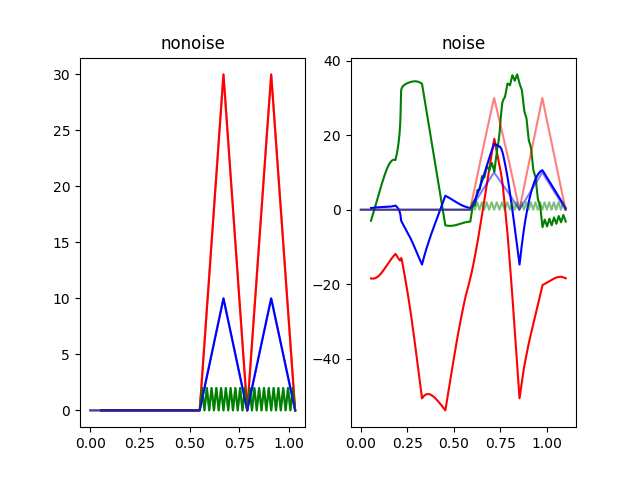

<IPython.core.display.Javascript object>


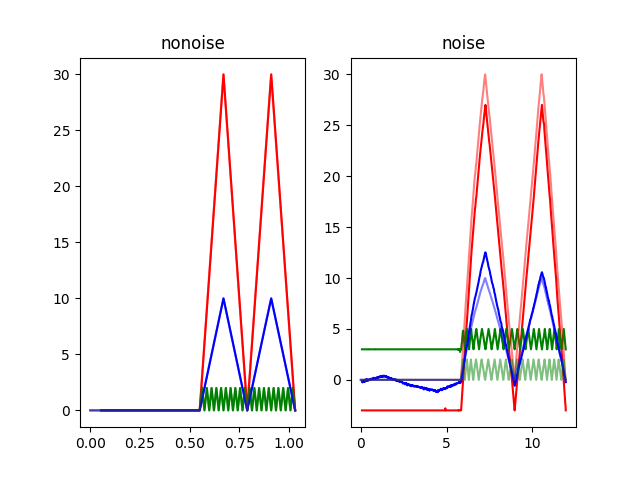

In [6]:
plt.figure('angle analysis pnp 1')
ax=plt.subplot(1,2,1)
ax.set_title('nonoise')
plot_euler_angles('out/sim_pnp_1_nonoise.pkl',ax)
ax=plt.subplot(1,2,2)
ax.set_title('noise')
plot_euler_angles('out/sim_pnp_1_noise.pkl',ax)
plt.figure('angle analysis pnp 3 constrained version')
ax=plt.subplot(1,2,1)
ax.set_title('nonoise')
plot_euler_angles('out/sim_pnp_1_nonoise.pkl',ax)
ax=plt.subplot(1,2,2)
ax.set_title('noise')
plot_euler_angles('out/sim_pnp_3_noise_constrains.pkl',ax)


<IPython.core.display.Javascript object>


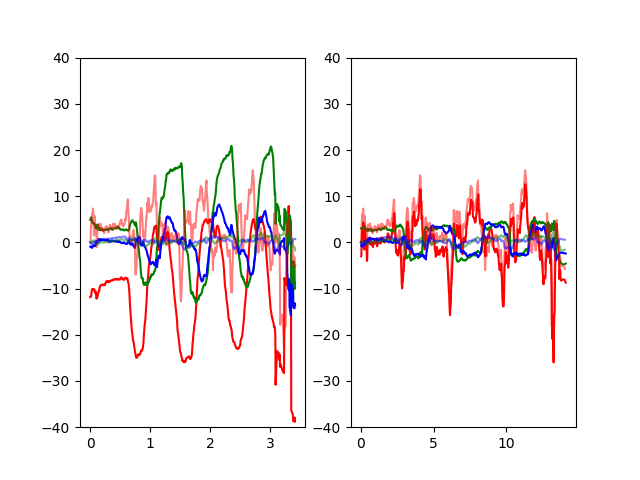

In [7]:
plt.figure('angle analysis on live optitrack scenario')
ax=plt.subplot(1,2,1)
ax.set_ylim((-40,40))
plot_euler_angles('out/optilive12_pnp_1.pkl',ax)
ax=plt.subplot(1,2,2)
ax.set_ylim((-40,40))
plot_euler_angles('out/optilive12_pnp_3_constrains.pkl',ax)


<IPython.core.display.Javascript object>


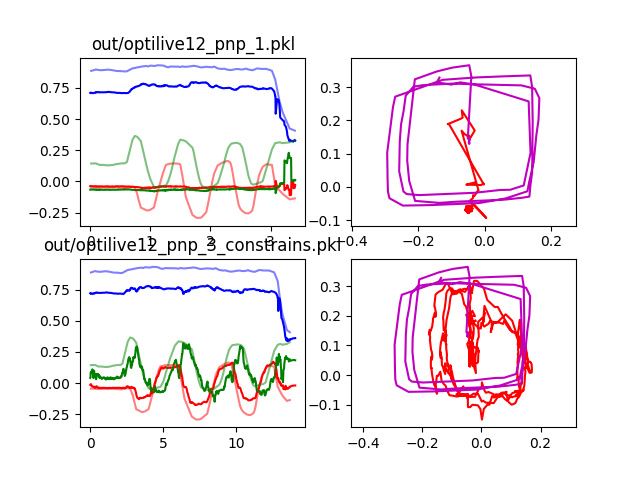

<IPython.core.display.Javascript object>


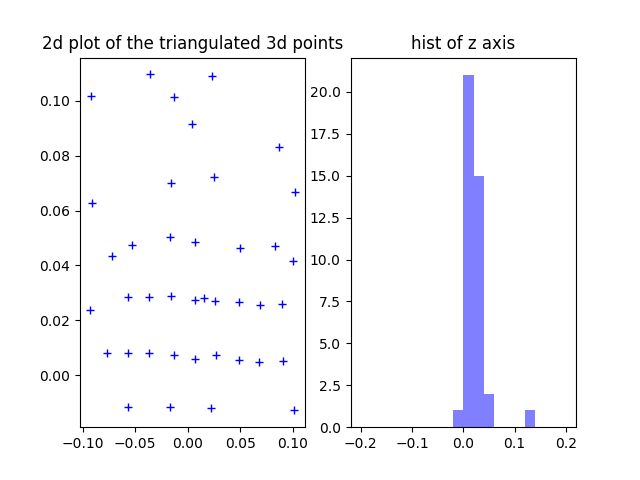

In [8]:
plt.figure()
plot_experiments('out/optilive12_pnp_1.pkl','out/optilive12_pnp_3_constrains.pkl','liveopti')
plt.figure()
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)
plot_3dpoints('out/optilive12_pnp_1.pkl',ax1,ax2,'b')


<IPython.core.display.Javascript object>


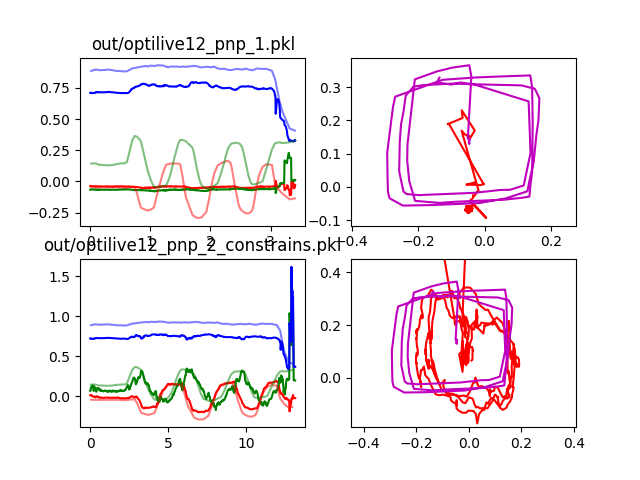

In [9]:
plt.figure()
plot_experiments('out/optilive12_pnp_1.pkl','out/optilive12_pnp_2_constrains.pkl','liveopti')


<IPython.core.display.Javascript object>


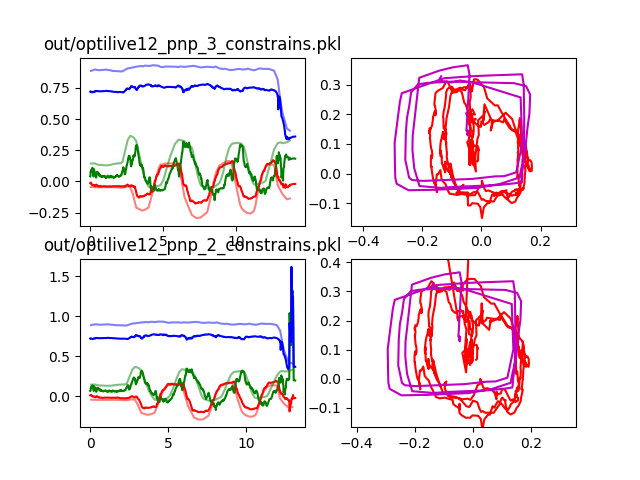

In [10]:
plt.figure()
plot_experiments('out/optilive12_pnp_3_constrains.pkl','out/optilive12_pnp_2_constrains.pkl','liveopti')


<IPython.core.display.Javascript object>


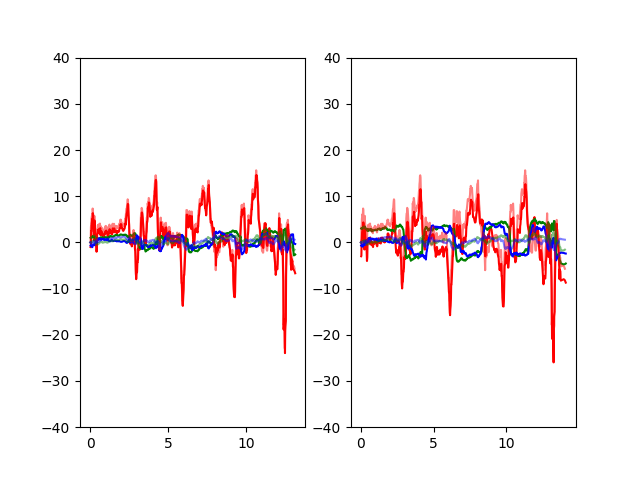

In [11]:
plt.figure()
ax=plt.subplot(1,2,1)
ax.set_ylim((-40,40))
plot_euler_angles('out/optilive12_pnp_2_constrains.pkl',ax)
ax=plt.subplot(1,2,2)
ax.set_ylim((-40,40))
plot_euler_angles('out/optilive12_pnp_3_constrains.pkl',ax)
